In [1]:
pip install pandas numpy matplotlib seaborn nltk scikit-learn joblib torch torchvision tqdm wordcloud


In [2]:
# 1. imports & settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
from tqdm.auto import tqdm
plt.rcParams["figure.figsize"] = (10,5)
sns.set(style="whitegrid")

RND=42
np.random.seed(RND)
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
df=pd.read_csv('/content/test(in).csv')

In [4]:
print("Rows,Cols:", df.shape)
df.head(5)

Rows,Cols: (2191, 4)


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [5]:
# 3. clean basic columns
df = df.rename(columns={"body":"message", "from":"from_email", "date":"date_str", "Subject":"subject"})
df['date'] = pd.to_datetime(df['date_str'], errors='coerce')    # real date
df['from_email'] = df['from_email'].astype(str)
df['sender'] = df['from_email'].str.extract(r'([^@]+)', expand=False).fillna(df['from_email'])
df['message'] = df['message'].astype(str)
df['message_len'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().apply(len)
print("Missing dates:", df['date'].isna().sum())
df = df.reset_index(drop=True)
df.head(4)


Missing dates: 0


,subject,message,date_str,from_email,date,sender,message_len,word_count
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,2010-05-10,sally.beck,692,101
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,2010-07-29,eric.bass,315,57
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,2011-07-25,sally.beck,150,21
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,2010-03-25,johnny.palmer,155,24


In [7]:
# 4. VADER labeling
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def label_vader(txt):
    sc = sid.polarity_scores(txt)['compound']
    if sc >= 0.05: return "positive", sc
    if sc <= -0.05: return "negative", sc
    return "neutral", sc

tqdm.pandas()
res = df['message'].progress_apply(label_vader)
df['sentiment'] = res.apply(lambda x: x[0])
df['vader_compound'] = res.apply(lambda x: x[1])
df['sentiment_num'] = df['sentiment'].map({'positive':1,'neutral':0,'negative':-1})
df['sentiment'].value_counts()
# save labeled file
df.to_csv("/content/test(in)2.csv", index=False)
print("Saved: /content/test(in)2.csv")


  0%|          | 0/2191 [00:00<?, ?it/s]

Saved: /content/test(in)2.csv


sentiment
positive    1528
neutral      511
negative     152
Name: count, dtype: int64


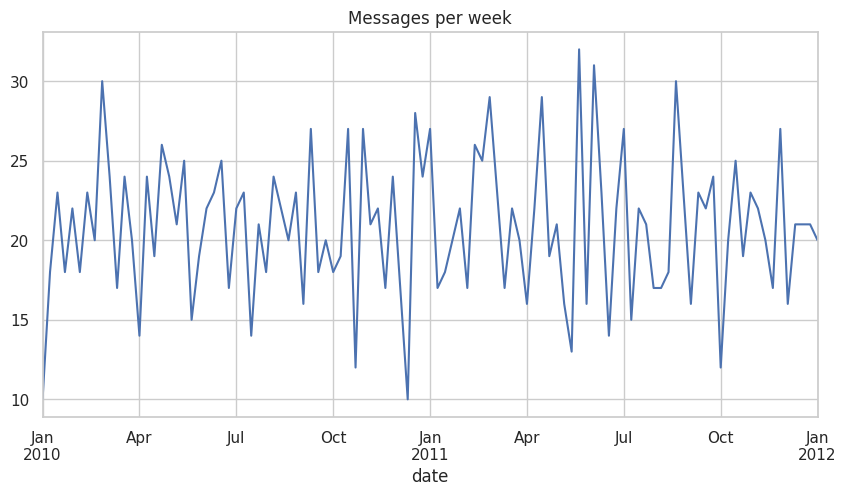

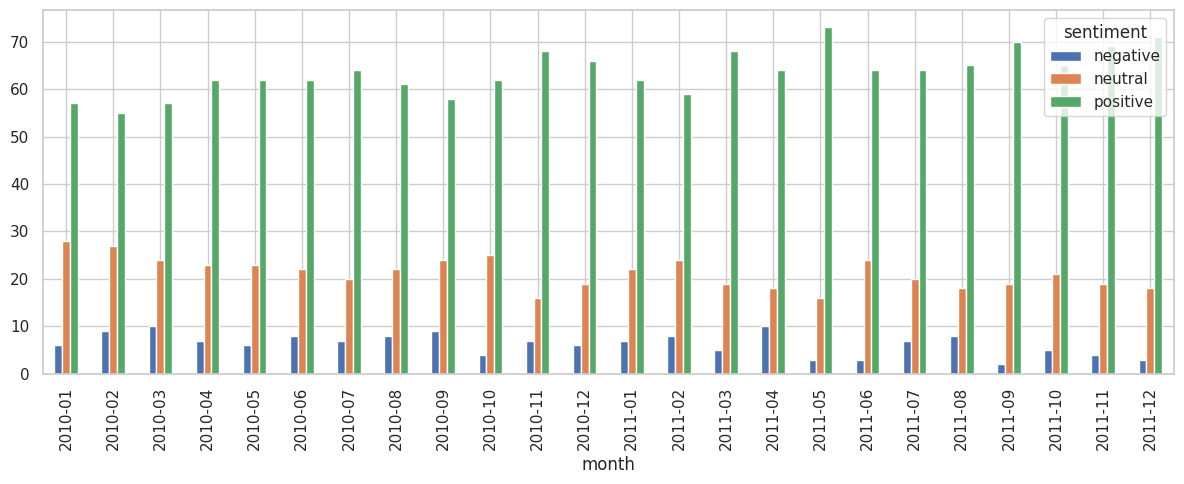

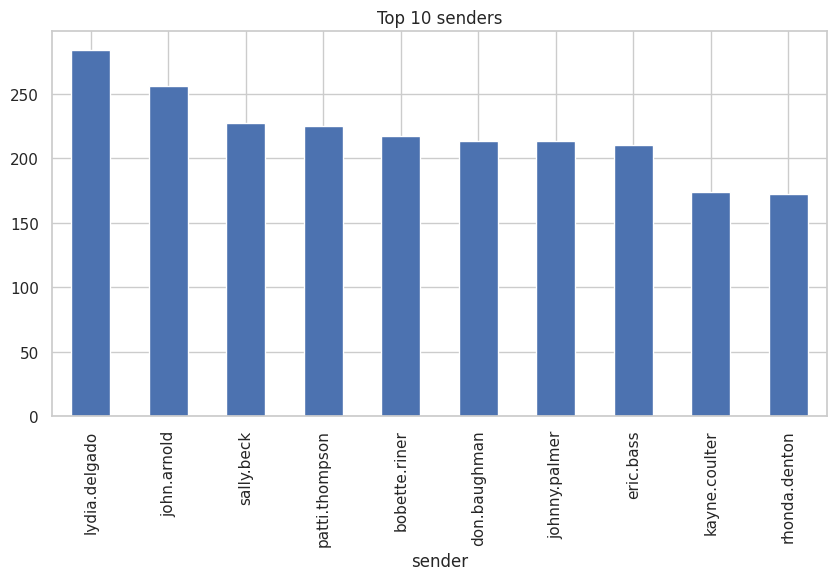

In [17]:
# 5a. sentiment counts
print(df['sentiment'].value_counts())

# 5b. messages per week
ts = df.set_index('date').resample('W')['message'].count()
ts.plot(title="Messages per week"); plt.savefig("messages_per_week.png"); plt.show()

# 5c. monthly sentiment counts
df['month'] = df['date'].dt.to_period('M')
monthly = df.groupby(['month','sentiment']).size().unstack(fill_value=0)
monthly.plot(kind='bar', stacked=False, figsize=(12,5)); plt.tight_layout()
plt.savefig("monthly_sentiment_counts.png"); plt.show()

# 5d. top senders by messages
df['sender'].value_counts().head(10).plot(kind='bar', title="Top 10 senders"); plt.savefig("top_senders.png"); plt.show()


In [19]:
# 6. monthly scores
df['month_ts'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly_scores = (df.groupby(['sender','month_ts'])
                    .agg(message_count=('message','count'),
                         pos_count=('sentiment', lambda s: (s=='positive').sum()),
                         neg_count=('sentiment', lambda s: (s=='negative').sum()),
                         neutral_count=('sentiment', lambda s: (s=='neutral').sum()),
                         avg_len=('message_len','mean'))
                    .reset_index())
# compute monthly_score = pos*1 + neg*(-1) + neutral*0 === sum of sentiment_num
monthly_scores['monthly_score'] = (df.groupby(['sender','month_ts'])['sentiment_num'].sum().values)
monthly_scores.to_csv("monthly_scores.csv", index=False)
monthly_scores.head(6)


,sender,month_ts,message_count,pos_count,neg_count,neutral_count,avg_len,monthly_score
0,bobette.riner,2010-01-01,2,1,0,1,115.000000,1
1,bobette.riner,2010-02-01,14,8,1,5,295.714286,7
2,bobette.riner,2010-03-01,11,7,1,3,286.181818,6
3,bobette.riner,2010-04-01,6,3,0,3,226.500000,3
4,bobette.riner,2010-05-01,4,2,0,2,172.250000,2
5,bobette.riner,2010-06-01,5,2,0,3,139.400000,2


In [20]:
# 7. top 3 pos and top 3 neg per month
def top3_for_month(month_ts):
    mdf = monthly_scores[monthly_scores['month_ts']==month_ts]
    top_pos = mdf.sort_values(['monthly_score','sender'], ascending=[False, True]).head(3)
    top_neg = mdf.sort_values(['monthly_score','sender'], ascending=[True, True]).head(3)
    return top_pos, top_neg

months = sorted(monthly_scores['month_ts'].unique())
for m in months[-3:]:   # show last 3 months
    pos, neg = top3_for_month(m)
    print("Month:", m)
    print(" Top 3 Positive:\n", pos[['sender','monthly_score','message_count']])
    print(" Top 3 Negative:\n", neg[['sender','monthly_score','message_count']])
    print("-"*40)


Month: 2011-10-01 00:00:00
 Top 3 Positive:
             sender  monthly_score  message_count
165  lydia.delgado             12             20
93     john.arnold             10             18
45    don.baughman              9              9
 Top 3 Negative:
             sender  monthly_score  message_count
21   bobette.riner              0              1
213  rhonda.denton              0              2
117  johnny.palmer              2              2
----------------------------------------
Month: 2011-11-01 00:00:00
 Top 3 Positive:
             sender  monthly_score  message_count
142  kayne.coulter             15             16
94     john.arnold             10             11
22   bobette.riner              9             16
 Top 3 Negative:
             sender  monthly_score  message_count
70       eric.bass              1              1
214  rhonda.denton              2              5
46    don.baughman              5              8
----------------------------------------
Month: 2

In [22]:
# 8. flight risk
def detect_flight_risks(df):
    risks = []
    for sender, group in df.groupby('sender'):
        neg_dates = group.loc[group['sentiment']=='negative','date'].sort_values().reset_index(drop=True)
        if len(neg_dates) < 4:
            continue
        n = len(neg_dates)
        for i in range(n-3):
            if (neg_dates.iloc[i+3] - neg_dates.iloc[i]) <= pd.Timedelta(days=30):
                risks.append({'sender': sender,
                              'first_neg': neg_dates.iloc[i].date(),
                              'fourth_neg': neg_dates.iloc[i+3].date()})
                break
    return pd.DataFrame(risks)

flight_risks = detect_flight_risks(df)
flight_risks.to_csv("flight_risks.csv", index=False)
print("Flight risks found:", len(flight_risks))
flight_risks.head()


Flight risks found: 4


,sender,first_neg,fourth_neg
0,bobette.riner,2010-09-10,2010-09-30
1,don.baughman,2010-12-12,2011-01-09
2,johnny.palmer,2010-02-09,2010-03-10
3,sally.beck,2011-08-06,2011-08-22


In [24]:
# 9. TF-IDF + Logistic Regression (sklearn) - message level classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# prepare
df2 = df.copy()
df2 = df2.dropna(subset=['message'])   # ensure messages exist
X_text = df2['message'].values
y_text = df2['sentiment'].map({'negative':0,'neutral':1,'positive':2}).values

tfv = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfv.fit_transform(X_text)

Xtr, Xte, ytr, yte = train_test_split(X_tfidf, y_text, test_size=0.2, random_state=RND)
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RND)
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)

print("Accuracy:", accuracy_score(yte, yp))
print(classification_report(yte, yp, target_names=['neg','neu','pos']))

# save model + vectorizer
joblib.dump({'clf':clf, 'vectorizer':tfv}, "sklearn_text_classifier.joblib")
print("Saved sklearn text classifier to code/sklearn_text_classifier.joblib")


Accuracy: 0.8382687927107062
              precision    recall  f1-score   support

         neg       0.67      0.52      0.59        42
         neu       0.76      0.79      0.78       107
         pos       0.89      0.90      0.89       290

    accuracy                           0.84       439
   macro avg       0.77      0.74      0.75       439
weighted avg       0.84      0.84      0.84       439

Saved sklearn text classifier to code/sklearn_text_classifier.joblib


In [28]:
# 1) Inspect available columns in monthly_scores (print so you can verify)
print("Available columns in monthly_scores:\n", monthly_scores.columns.tolist())

# 2) Create/ensure needed derived columns (safe)
m = monthly_scores.copy().sort_values(['sender','month_ts']).reset_index(drop=True)

# If lag_score missing, create it
if 'lag_score' not in m.columns:
    m['lag_score'] = m.groupby('sender')['monthly_score'].shift(1).fillna(0)

# If pct_neg missing, create it (guard divide by zero)
if 'pct_neg' not in m.columns:
    m['pct_neg'] = (m['neg_count'] / m['message_count']).replace([np.inf, -np.inf], 0).fillna(0)

# If avg_words not present, fill with avg_len or with zeros
if 'avg_words' not in m.columns:
    if 'avg_len' in m.columns:
        # fallback: approximate avg_words by message_len / 5 (rough) OR use zeros
        m['avg_words'] = (m['avg_len'] / 5).fillna(0)
    else:
        m['avg_words'] = 0

m = m.fillna(0)

# 3) Desired features list (what we *intend* to use)
desired_features = ['message_count','avg_len','avg_words','pos_count','neg_count','pct_neg','lag_score']

# 4) Keep only those desired features that actually exist in m
features = [f for f in desired_features if f in m.columns]
missing = [f for f in desired_features if f not in m.columns]
print("\nUsing features:", features)
if missing:
    print("Warning - these desired features were missing and removed:", missing)

# 5) Check there are at least 1 feature
if len(features) == 0:
    raise ValueError("No valid features available for regression. Check monthly_scores columns.")

# 6) Prepare X and y
X = m[features].values
y = m['monthly_score'].values

# 7) Train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# 8) Scale features
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# 9) Fit linear regression
lr = LinearRegression()
lr.fit(Xtr_s, ytr)
yp = lr.predict(Xte_s)

# 10) Metrics
mae = mean_absolute_error(yte, yp)
r2 = r2_score(yte, yp)
print(f"\nLinear Regression results -> MAE: {mae:.4f}, R2: {r2:.4f}")

# 11) Show coefficients mapped to feature names (if shapes match)
coefs = lr.coef_
if len(coefs) == len(features):
    coef_series = {feat: round(float(c), 6) for feat, c in zip(features, coefs)}
    print("\nCoefficients (feature : coefficient):")
    for k,v in coef_series.items():
        print(f"  {k}: {v}")
else:
    print("Note: number of coefficients does not match number of features. Coefs shape:", coefs.shape)

# 12) Save model + scaler + features
os.makedirs("code", exist_ok=True)
joblib.dump({'model':lr, 'scaler':scaler, 'features':features}, "code/linreg_monthly.joblib")
print("\nSaved linear regression to code/linreg_monthly.joblib")

Available columns in monthly_scores:
 ['sender', 'month_ts', 'message_count', 'pos_count', 'neg_count', 'neutral_count', 'avg_len', 'monthly_score']

Using features: ['message_count', 'avg_len', 'avg_words', 'pos_count', 'neg_count', 'pct_neg', 'lag_score']

Linear Regression results -> MAE: 0.0000, R2: 1.0000

Coefficients (feature : coefficient):
  message_count: -0.0
  avg_len: 0.0
  avg_words: -0.0
  pos_count: 4.272888
  neg_count: -0.821201
  pct_neg: -0.0
  lag_score: 0.0

Saved linear regression to code/linreg_monthly.joblib


In [29]:
# 11. optional small PyTorch classifier on TF-IDF features
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# convert sparse TF-IDF to dense (may be big — ok for small datasets)
X_dense = X_tfidf.toarray().astype(np.float32)
y_lbl = y_text.astype(np.int64)
Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(X_dense, y_lbl, test_size=0.2, random_state=RND)

# tensors + loaders
tr_ds = TensorDataset(torch.tensor(Xtr_d), torch.tensor(ytr_d))
te_ds = TensorDataset(torch.tensor(Xte_d), torch.tensor(yte_d))
tr_loader = DataLoader(tr_ds, batch_size=32, shuffle=True)
te_loader = DataLoader(te_ds, batch_size=64)

class TinyNet(nn.Module):
    def __init__(self, in_dim, n_classes=3):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim,128), nn.ReLU(), nn.Dropout(0.3),
                                 nn.Linear(128,64), nn.ReLU(), nn.Linear(64,n_classes))
    def forward(self,x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet(Xtr_d.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# train for 5 epochs (small)
for epoch in range(5):
    model.train()
    total=0
    for xb,yb in tr_loader:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = loss_fn(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    print("Epoch", epoch+1, "loss", total/len(tr_ds))

# quick eval
model.eval()
all_preds=[]
all_labels=[]
with torch.no_grad():
    for xb,yb in te_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds); all_labels.extend(yb.numpy())
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['neg','neu','pos']))
# save model
torch.save(model.state_dict(), "code/torch_text_classifier.pth")
print("Saved PyTorch model to code/torch_text_classifier.pth")


Epoch 1 loss 0.8497002993000152
Epoch 2 loss 0.5365864129643462
Epoch 3 loss 0.30963860227637097
Epoch 4 loss 0.17966147495187038
Epoch 5 loss 0.1229447526304417
Accuracy: 0.8496583143507973
              precision    recall  f1-score   support

         neg       1.00      0.29      0.44        42
         neu       0.80      0.76      0.78       107
         pos       0.86      0.97      0.91       290

    accuracy                           0.85       439
   macro avg       0.89      0.67      0.71       439
weighted avg       0.86      0.85      0.83       439

Saved PyTorch model to code/torch_text_classifier.pth


In [30]:
# 12. Save files already created (examples)
df.to_csv("/content/test(in)2.csv", index=False)
monthly_scores.to_csv("/content/test(in)2.csv", index=False)
flight_risks.to_csv("flight_risks.csv", index=False)
# models saved earlier with joblib / torch.save
print("Files saved. Prepare README and final_report.docx using these outputs.")


Files saved. Prepare README and final_report.docx using these outputs.
